# Loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import helper as hp

import os
from abc import ABC, abstractmethod
from collections import defaultdict
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller, kpss
from models import * 

current_path = os.getcwd()
random_state = hp.RANDOM_STATE

current_path = os.getcwd()
random_state = hp.RANDOM_STATE
STOCKS = ["TSLA", "AAPL", 'QQQ', "SPY", "MSFT", "AMZN", "GOOG", "DIA", "^IRX"]
START_DATE = hp.START_DATE
END_DATE = hp.END_DATE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# data fetching 
stock_data = {}
for stock in STOCKS:
    data_path = os.path.join(current_path, "data", f"{stock}_{START_DATE}_{END_DATE}.csv")
    data = pd.read_csv(data_path)
    stock_data[stock] = data
stock_data = hp.preprocess_stock_data(stock_data, STOCKS)

Data fetched for TSLA
Data fetched for AAPL
Data fetched for QQQ
Data fetched for SPY
Data fetched for MSFT
Data fetched for AMZN
Data fetched for GOOG
Data fetched for DIA
Data fetched for ^IRX


## Paramenters

In [ ]:
fromDate = "2015-01-01"
toDate = '2023-01-01'
# fromDate = "2015-01-01"
# toDate = '2017-01-01'
stock = 'AAPL'
lag = 5
window_size = 10
starting_funds = 50000

# Non-Stationary

In [4]:
stationary = False
X, y, df_stock = hp.prepare_data(stock_data, stock, fromDate, toDate, lag, stationary=stationary)

## XGBoost

In [5]:
loss_fn = 'reg:squarederror' #'reg:pseudohubererror'
xgboost_model = XGBoost(loss_fn)
xgboost_stock_predictor = StockPredictor(xgboost_model, window_size=window_size, stationary=stationary)
xgboost_stock_predictor.fit_predict(X, y, df_stock)
xgboost_stock_predictor.print_metrics()

Processing: 100%|██████████| 225/225 [00:07<00:00, 30.90it/s]

Mean Squared Error (MSE): 11.1380
Mean Absolute Error (MAE): 2.5950


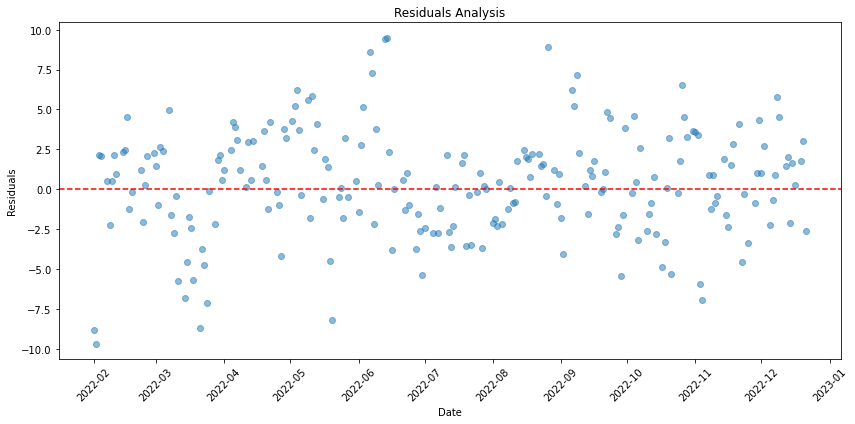

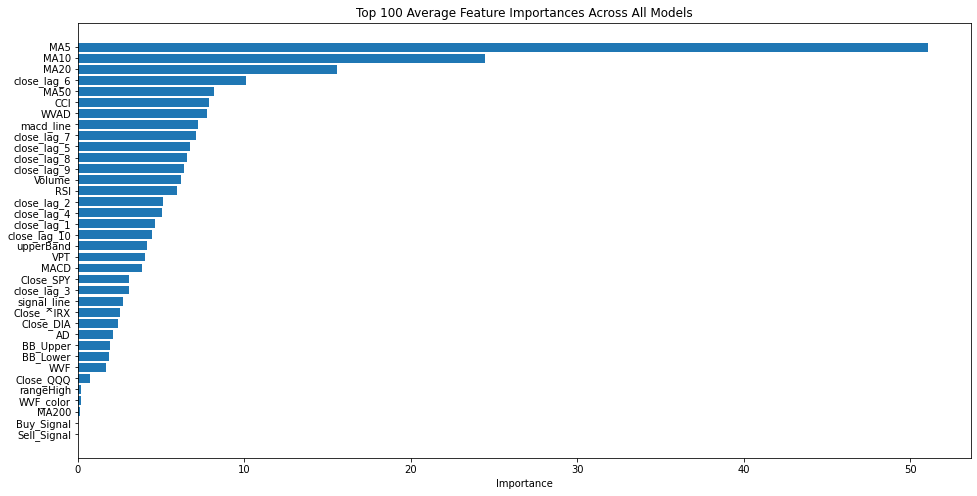

In [6]:
xgboost_stock_predictor.plot_residuals()
xgboost_stock_predictor.show_feature_importance(n=100)

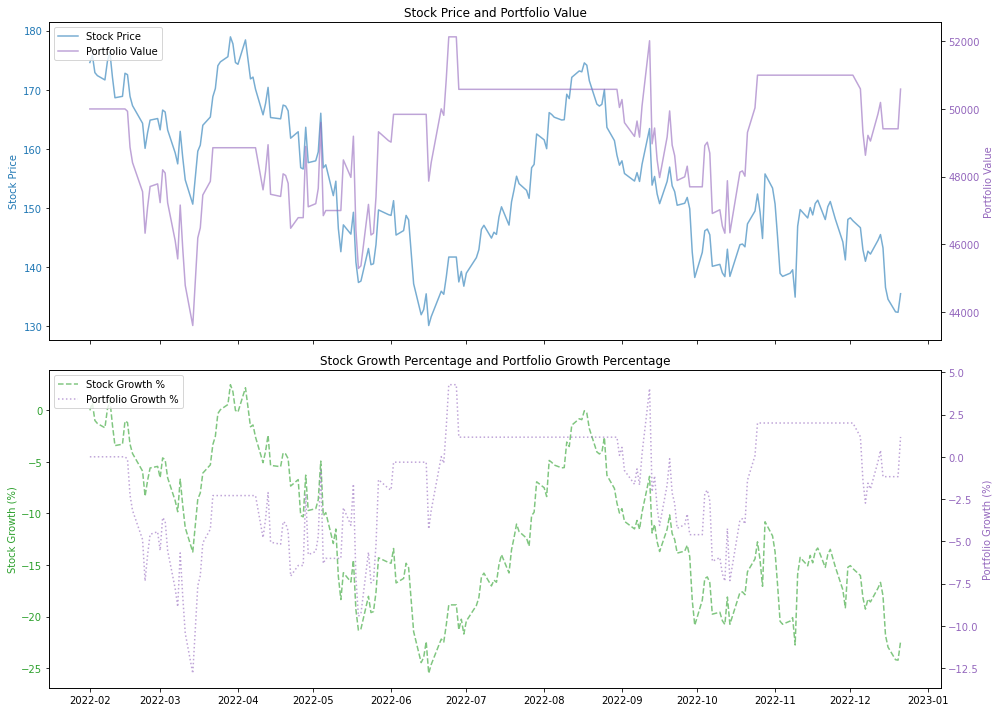

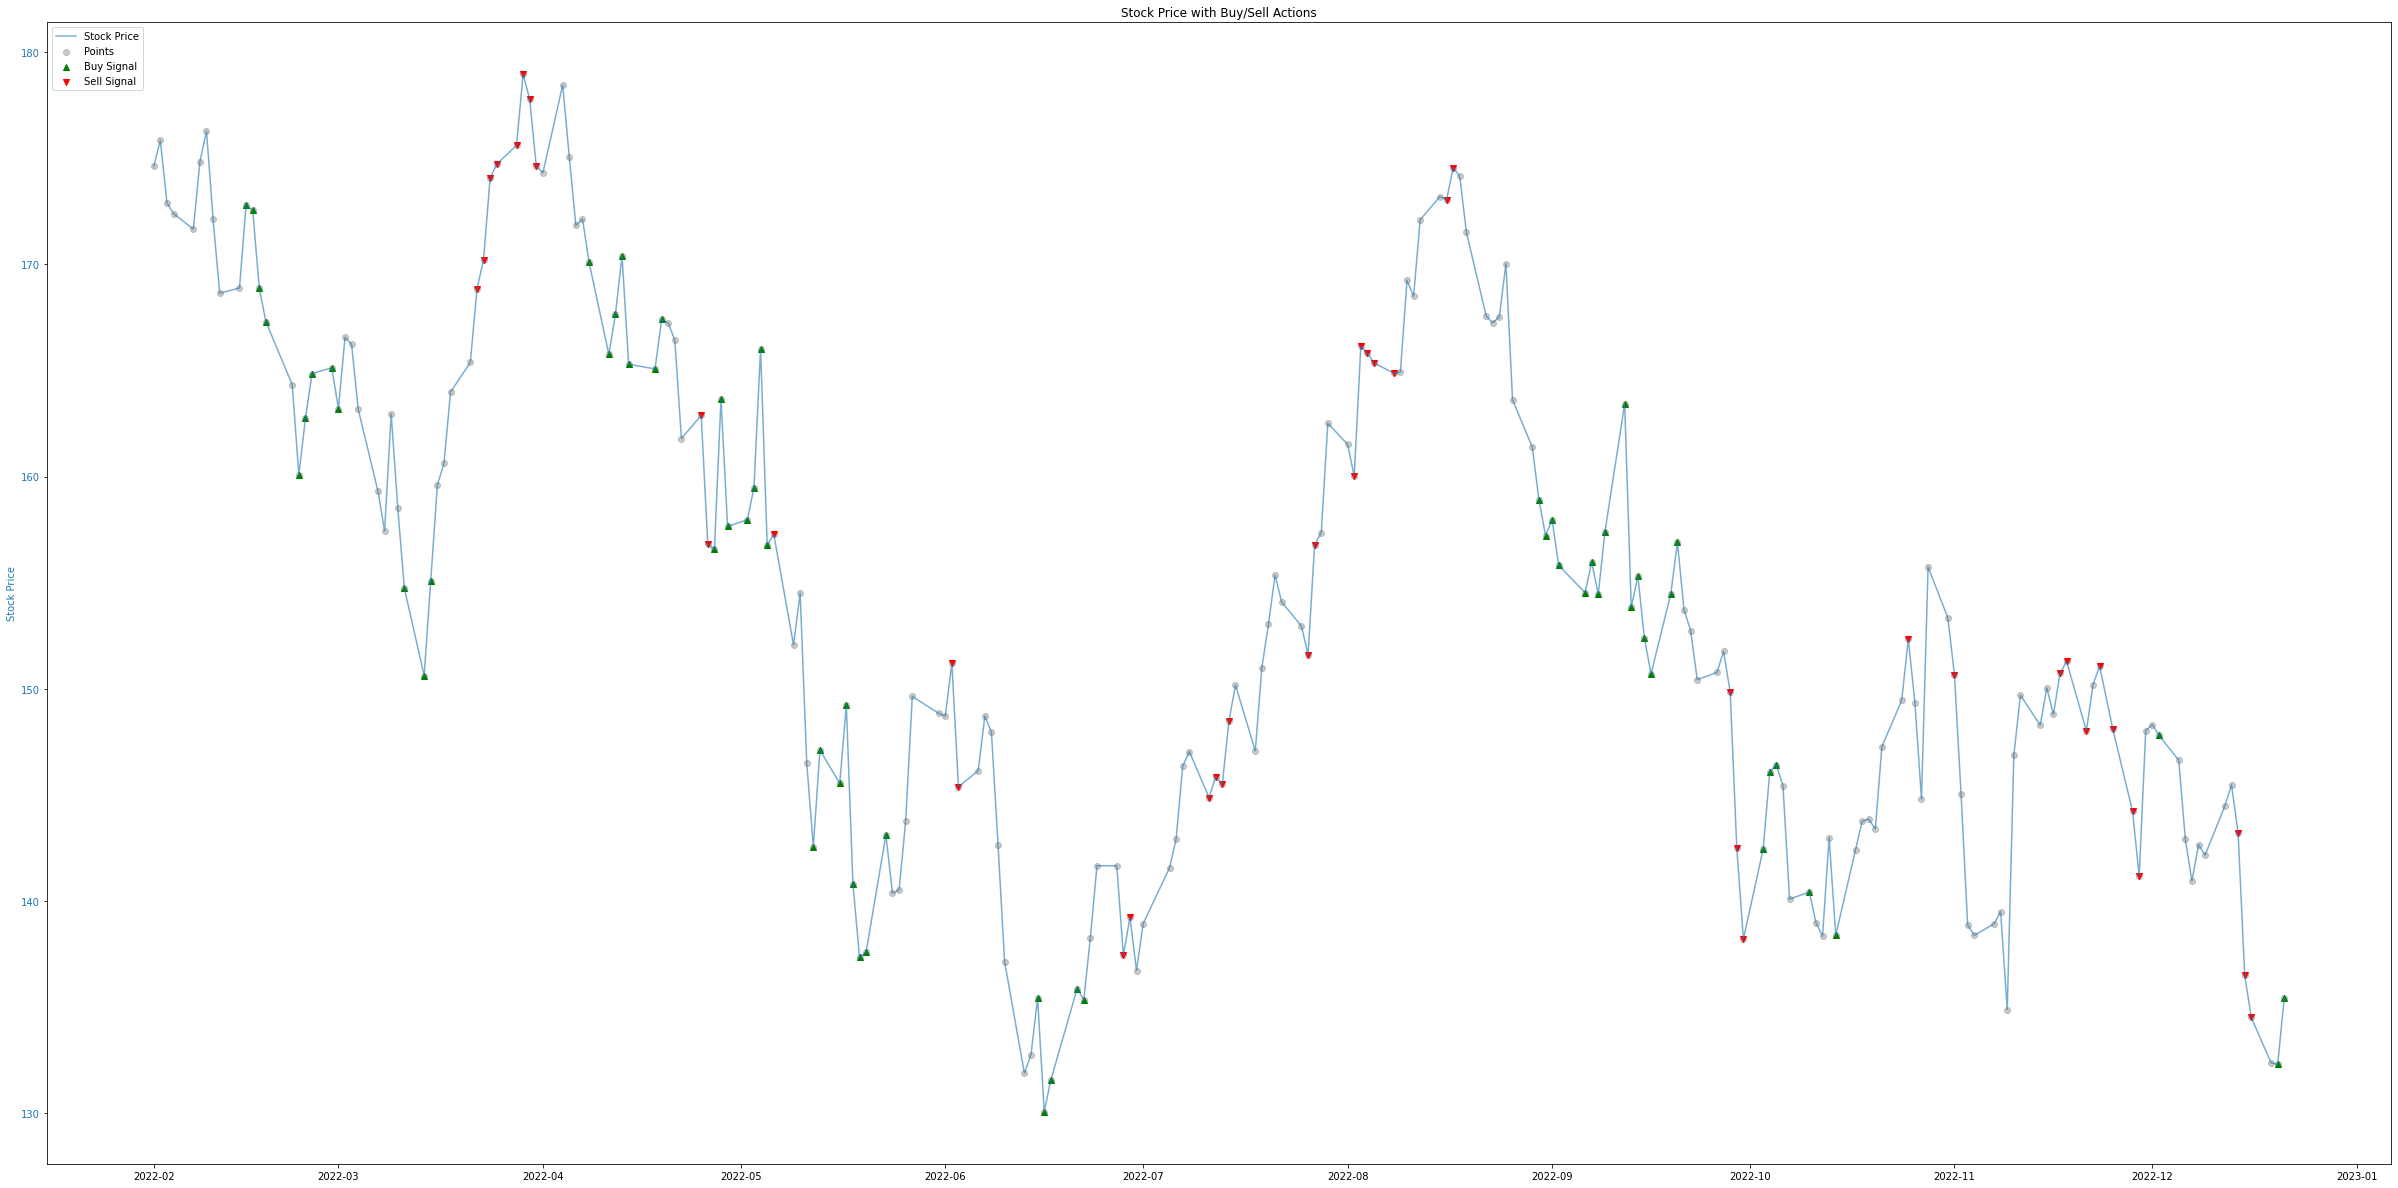

In [7]:
hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
    true_returns=xgboost_stock_predictor.true_returns,
    predicted_returns=xgboost_stock_predictor.predicted_returns,
    starting_funds=50000
)

## Random Forest

In [9]:
loss_fn = "squared_error" #'absolute_error', 'poisson', 'friedman_mse', 'squared_error'
rf_model = RandomForest(loss_fn)
rf_stock_predictor = StockPredictor(rf_model, window_size=window_size, stationary=stationary)
rf_stock_predictor.fit_predict(X, y, df_stock)
rf_stock_predictor.print_metrics()

Processing: 100%|██████████| 225/225 [00:35<00:00,  6.32it/s]


Mean Squared Error (MSE): 7.9580
Mean Absolute Error (MAE): 2.3179


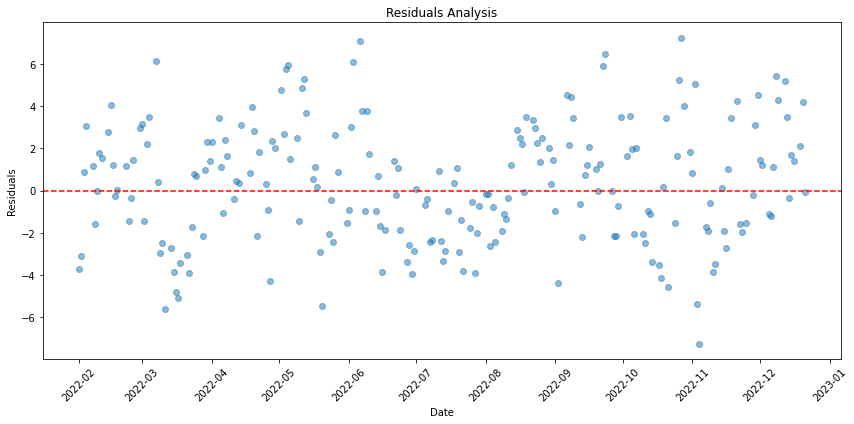

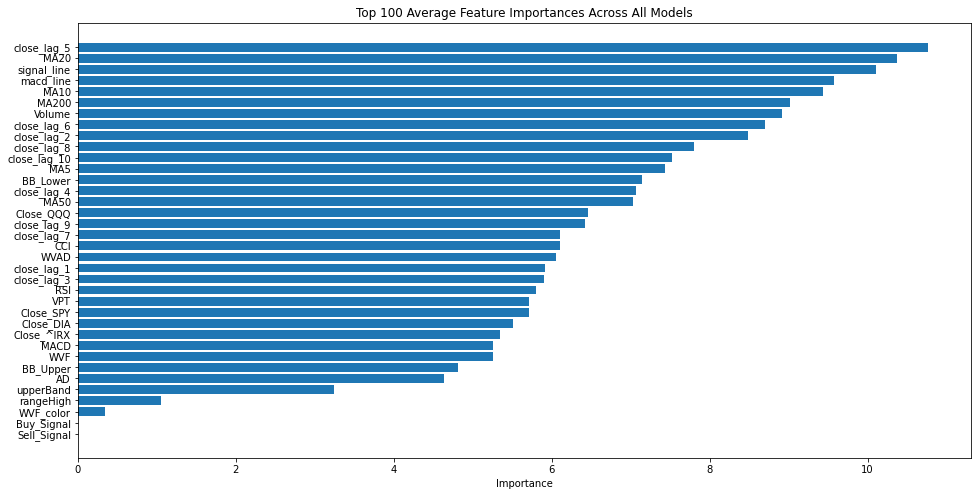

In [10]:
rf_stock_predictor.plot_residuals()
rf_stock_predictor.show_feature_importance(n=100)

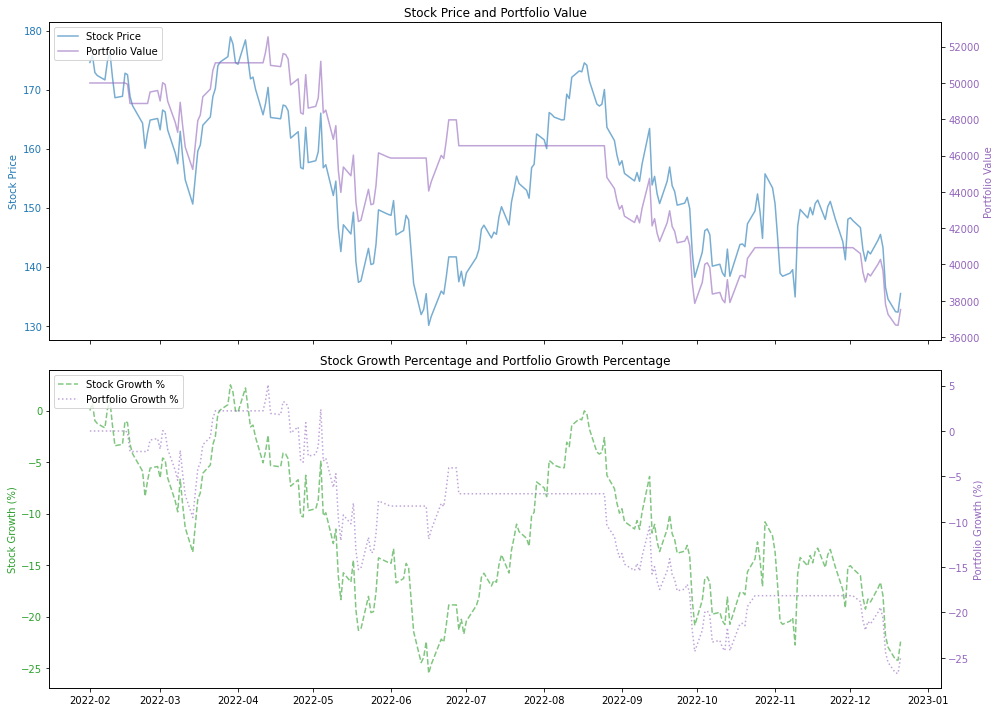

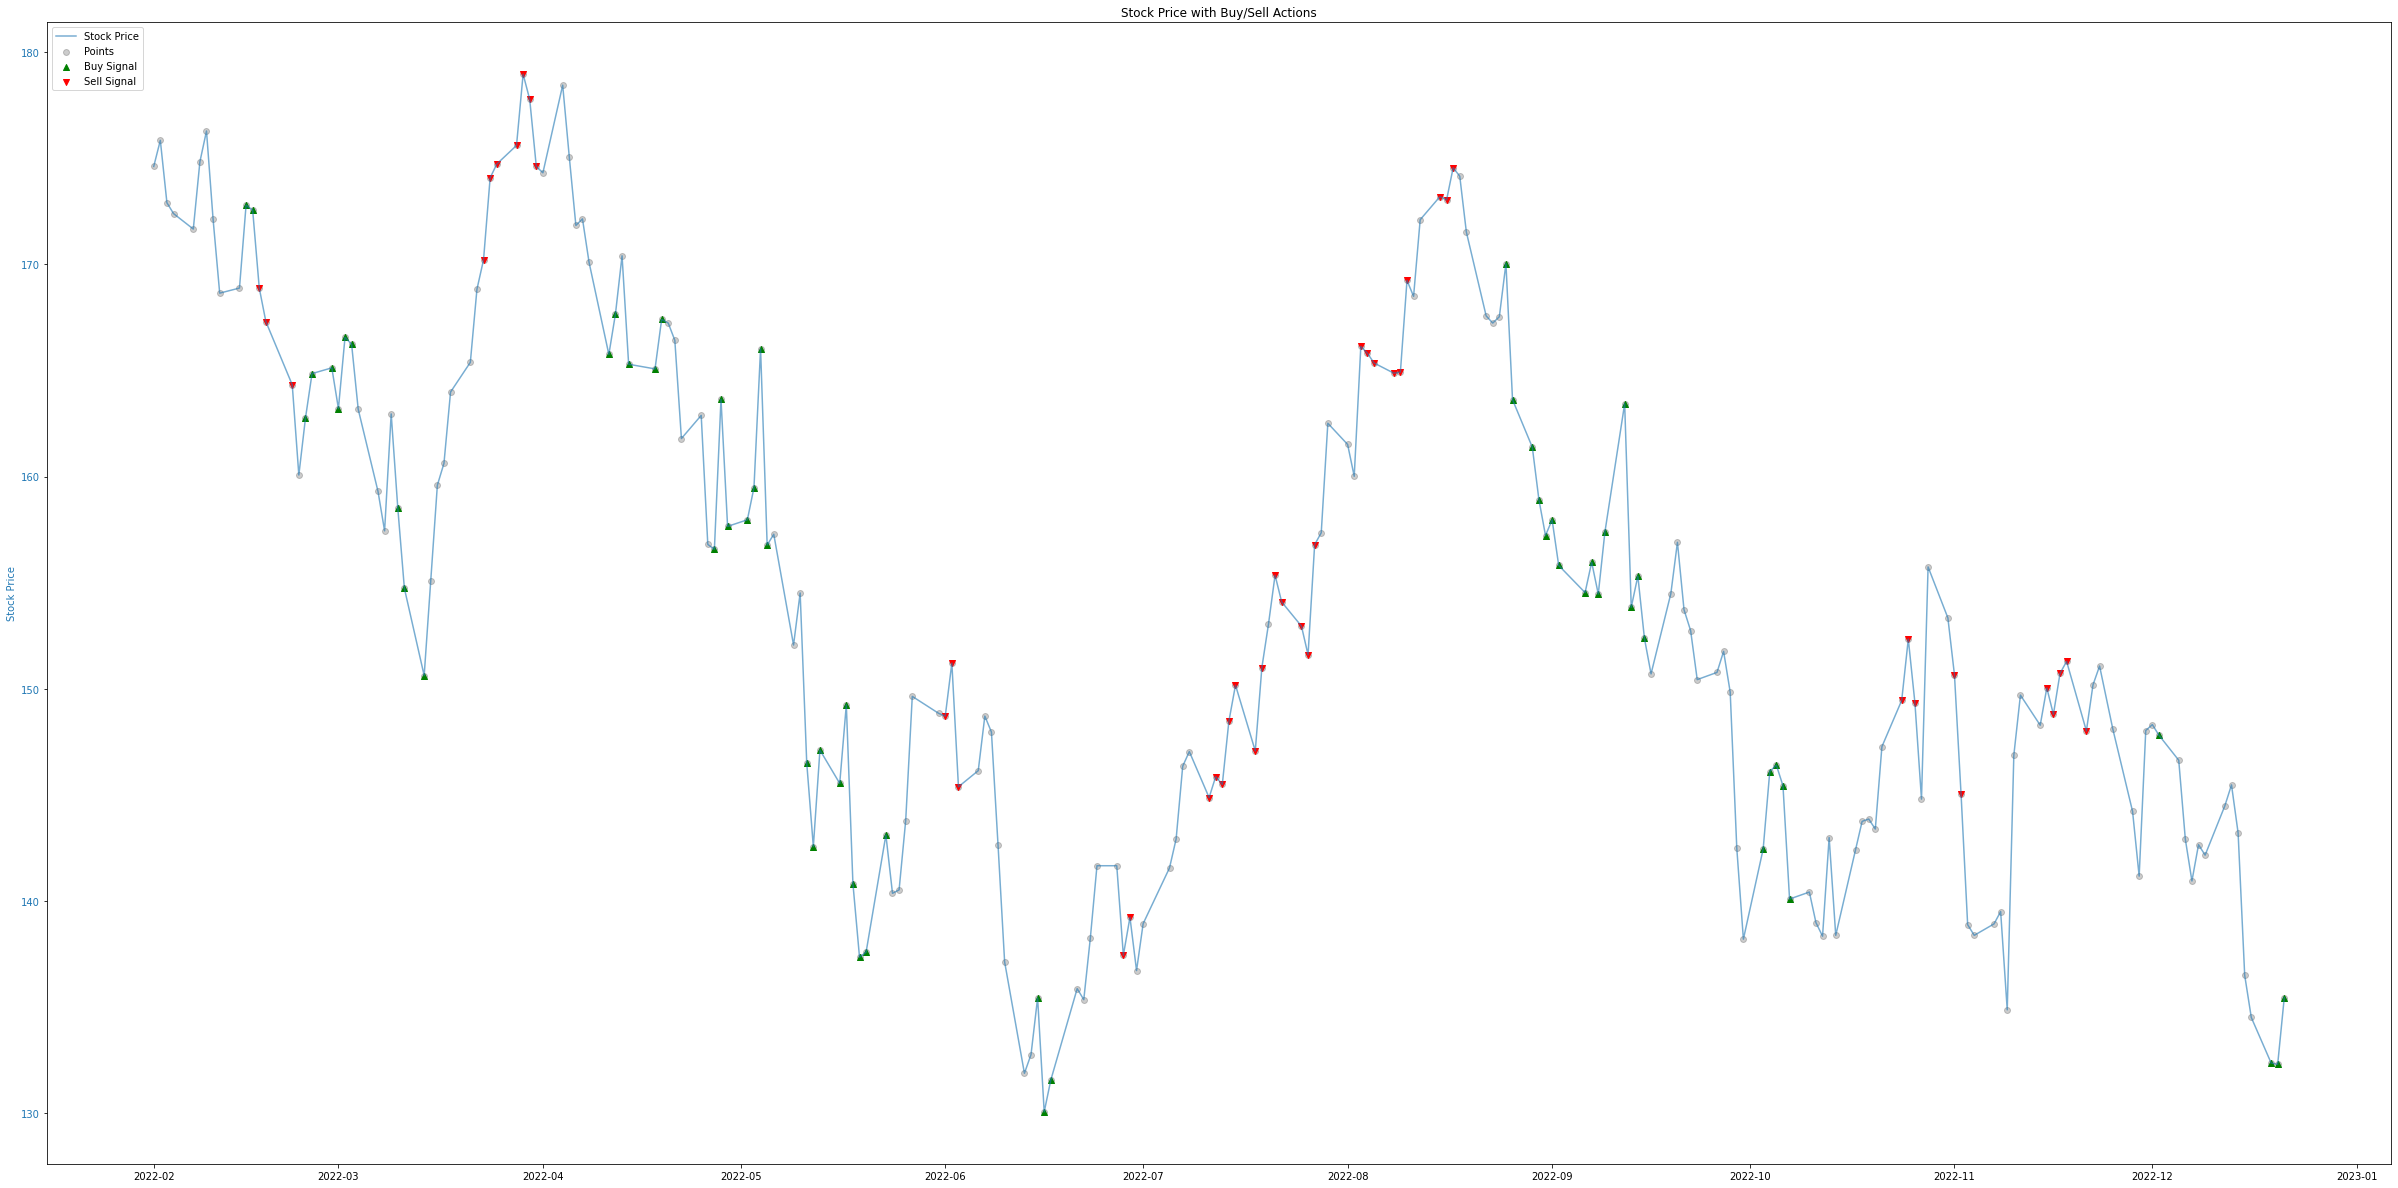

In [11]:
hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
    true_returns=rf_stock_predictor.true_returns,
    predicted_returns=rf_stock_predictor.predicted_returns,
    starting_funds=50000
)

## LSTM

# Stationary

## Stationarity Check

In [12]:
significance_level = 0.05  
data = stock_data['AAPL']
results = []

for feature in data.columns:
    if pd.api.types.is_numeric_dtype(data[feature]):
        result = adfuller(data[feature])
        p_value = result[1]
        is_stationary = "stationary" if p_value < significance_level else "nonstationary"
        results.append([feature, is_stationary, p_value])

feature_stationarity = pd.DataFrame(results, columns=["Feature", "Stationarity", "p-value"])
feature_stationarity = feature_stationarity.sort_values(by="Stationarity")

nonstationary_features_list = feature_stationarity.loc[feature_stationarity['Stationarity'] == 'nonstationary', 'Feature'].tolist()
print(nonstationary_features_list)
feature_stationarity.sort_values('p-value', ascending=False)

['Open', 'VPT', 'BB_Lower', 'BB_Upper', 'ATR', 'SMA', 'Lower Band', 'Upper Band', 'MA200', 'MA100', 'AD', 'MA20', 'High', 'Low', 'Close', 'MA50', 'Volume', 'MA5', 'Adj Close', 'MA10']


,Feature,Stationarity,p-value
10,MA50,nonstationary,9.859434e-01
30,BB_Upper,nonstationary,9.852933e-01
19,Upper Band,nonstationary,9.696534e-01
8,MA10,nonstationary,9.598414e-01
7,MA5,nonstationary,9.581930e-01
9,MA20,nonstationary,9.568627e-01
21,SMA,nonstationary,9.568627e-01
20,Lower Band,nonstationary,9.550818e-01
1,High,nonstationary,9.442359e-01
2,Low,nonstationary,9.424528e-01


In [13]:
stock_data_stationary = stock_data.copy()
for stock in stock_data: 
    data = stock_data[stock]
    if stock != "^IRX":
        # convert price related features into something stationary
        for feature in helper.PRICE_FEATURES_TO_CONVERT:
            data[feature] = (data[feature] - data['Close']) / data['Close']
        for feature in helper.ORIGINAL_PRICE_FEATURES:
            data[f'{feature}_diff'] = data[feature].pct_change() * 100

        # convert volume related features into something stationary
        data['Volume_MA5'] = data['Volume'].rolling(window=5).mean()
        data['Volume_MA_diff'] = (data['Volume'] - data['Volume_MA5'])/(data['Volume_MA5'])
            
        data = data.dropna()
    stock_data_stationary[stock] = data

In [14]:
data = stock_data_stationary['AAPL']
results = []

for feature in data.columns.drop(helper.ORIGINAL_PRICE_FEATURES + helper.VOLUME_FEATURES_TO_CONVERT):
    if pd.api.types.is_numeric_dtype(data[feature]):
        result = adfuller(data[feature])
        p_value = result[1]
        is_stationary = "stationary" if p_value < significance_level else "nonstationary"
        results.append([feature, is_stationary, p_value])

feature_stationarity = pd.DataFrame(results, columns=["Feature", "Stationarity", "p-value"])
feature_stationarity = feature_stationarity.sort_values(by="Stationarity")

nonstationary_features_list = feature_stationarity.loc[feature_stationarity['Stationarity'] == 'nonstationary', 'Feature'].tolist()
feature_stationarity.sort_values('p-value', ascending=False)


,Feature,Stationarity,p-value
17,ATR,nonstationary,4.661265e-01
27,VPT,nonstationary,2.468781e-01
35,Volume_MA5,nonstationary,1.142711e-01
29,AD,stationary,3.059457e-02
25,BB_Lower,stationary,4.563890e-03
6,MA200,stationary,3.752741e-03
24,BB_Upper,stationary,1.645676e-03
26,OBV,stationary,1.102144e-03
5,MA100,stationary,1.086421e-06
20,rangeHigh,stationary,3.646160e-07


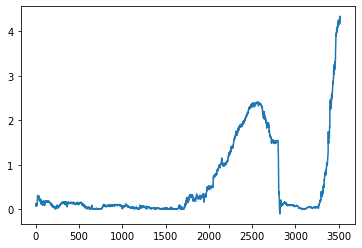

In [15]:
plt.plot(stock_data_stationary['^IRX']['Close'])

## Preprocessing

In [17]:
stationary = True
X, y, df_stock = hp.prepare_data(stock_data_stationary, stock, fromDate, toDate, lag, stationary=stationary)

## XGBoost

In [19]:
loss_fn = 'reg:squarederror' #'reg:pseudohubererror'
xgboost_model = XGBoost(loss_fn)
xgboost_stock_predictor = StockPredictor(xgboost_model, window_size=window_size, stationary=stationary)
xgboost_stock_predictor.fit_predict(X, y, df_stock)
xgboost_stock_predictor.print_metrics()

Processing: 100%|██████████| 225/225 [00:06<00:00, 34.16it/s]

Mean Squared Error (MSE): 9.7351
Mean Absolute Error (MAE): 2.4764


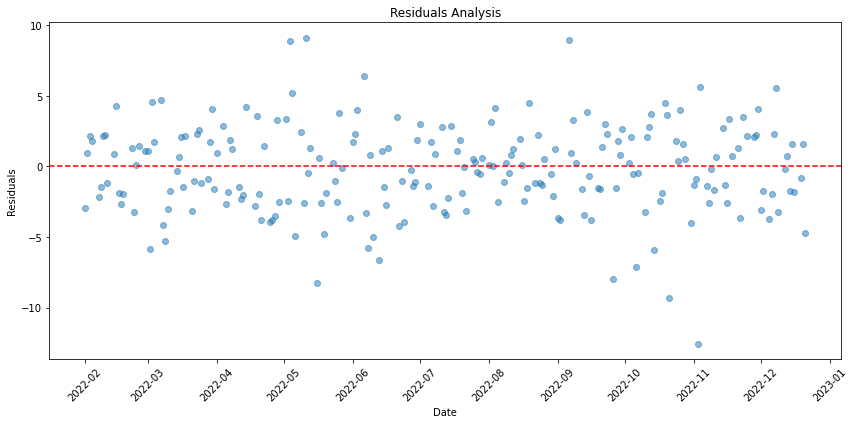

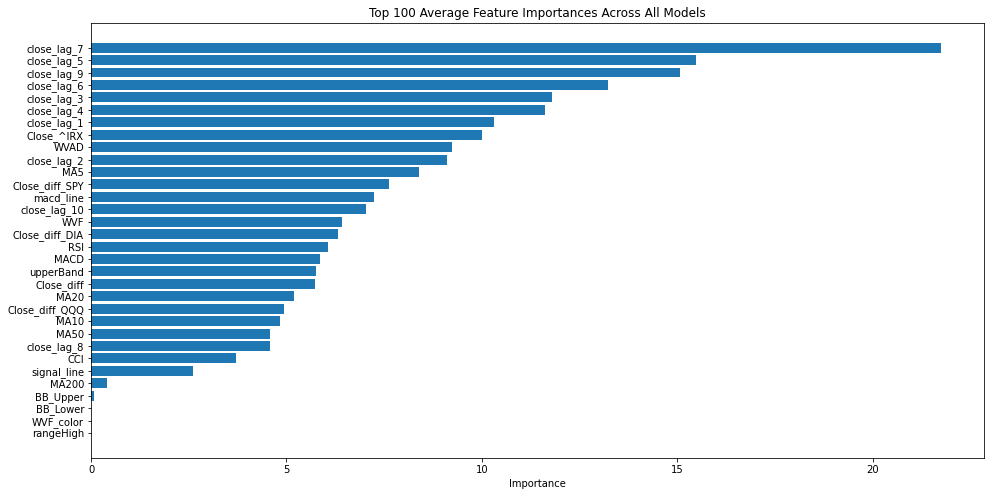

In [20]:
xgboost_stock_predictor.plot_residuals()
xgboost_stock_predictor.show_feature_importance(n=100)

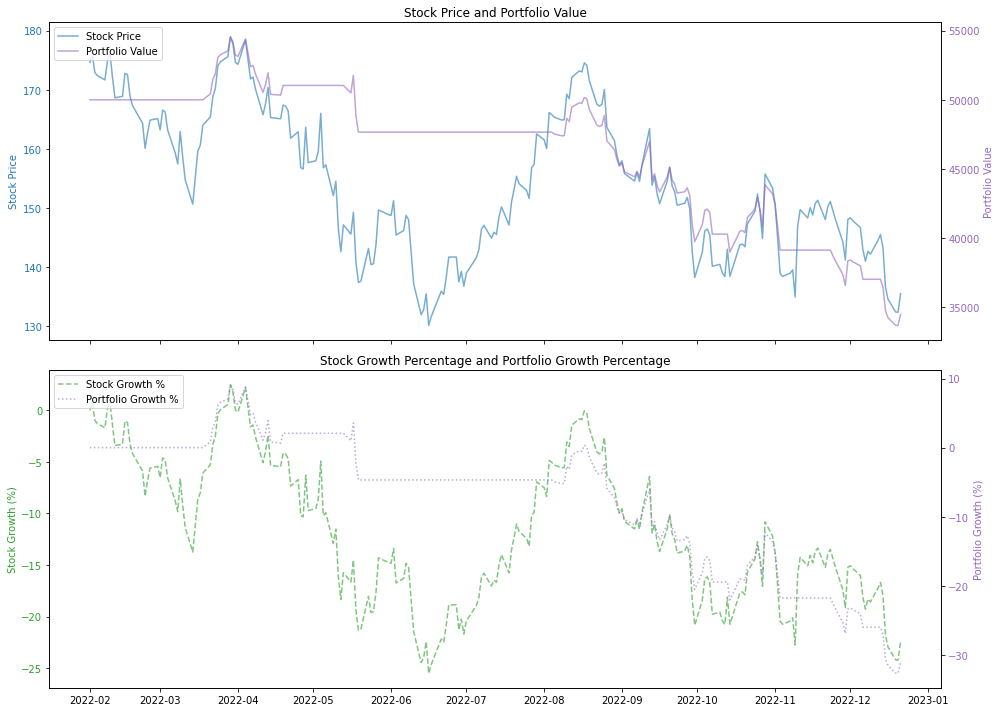

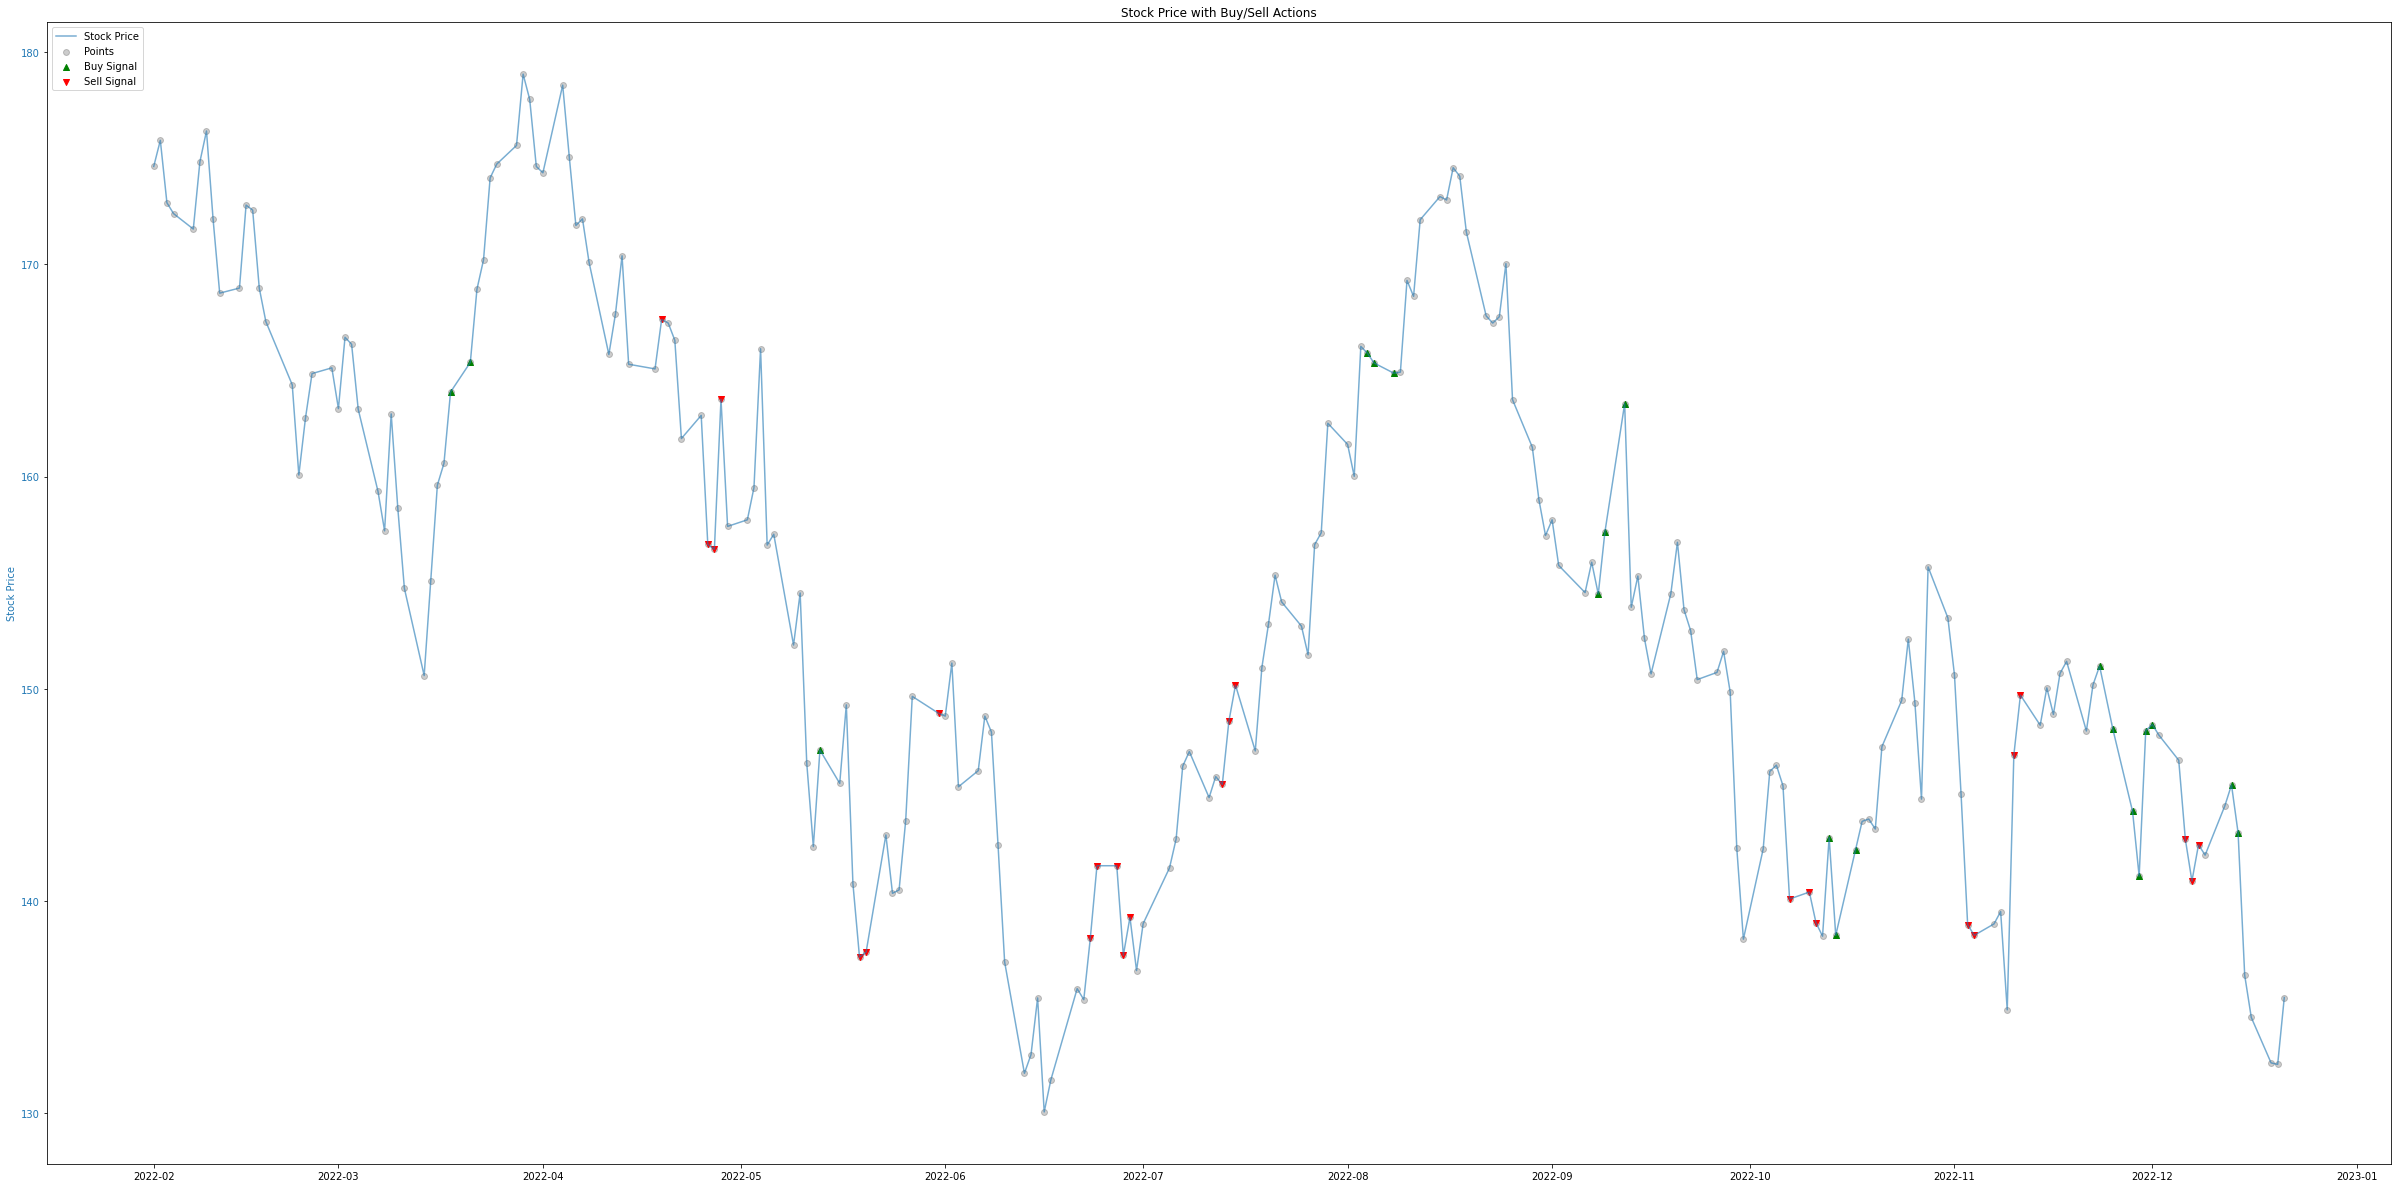

In [21]:
hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
    true_returns=xgboost_stock_predictor.true_returns,
    predicted_returns=xgboost_stock_predictor.predicted_returns,
    starting_funds=50000
)

## Random Forest

In [ ]:
loss_fn = "squared_error" #'absolute_error', 'poisson', 'friedman_mse', 'squared_error'
rf_model = RandomForest(loss_fn)
rf_stock_predictor = StockPredictor(rf_model, window_size=window_size, stationary=stationary)
rf_stock_predictor.fit_predict(X, y)
rf_stock_predictor.print_metrics()

In [ ]:
rf_stock_predictor.plot_residuals()
rf_stock_predictor.show_feature_importance(n=100)

In [ ]:
hp.trading_strategy(df_stock=df_stock, window_size=window_size, 
    true_returns=xgboost_stock_predictor.true_returns,
    predicted_returns=xgboost_stock_predictor.predicted_returns,
    starting_funds=50000
)

## LSTM